In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import librosa
import librosa.display
from PIL import Image

import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


from sklearn.metrics import classification_report
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [90]:
df_real = pd.DataFrame()
df_spoof = pd.DataFrame()

In [91]:
# read audio data

path = 'C:/Users/duran/Downloads/Training_Data/human'
path2 = 'C:/Users/duran/Downloads/Training_Data/spoof'
real = np.array([f for f in listdir(path) if isfile(join(path, f))])
spoof = [f for f in listdir(path2) if isfile(join(path2, f))]

df_real['path'] = real
df_spoof['path'] = spoof
df_real['path'] = path + '/'+ df_real['path']
df_spoof['path'] = path2 + '/'+  df_spoof['path']

data = pd.concat([df_real, df_spoof], ignore_index = True)

In [94]:
def audio_to_img(df, folder_name):
    
    ''' Convert audio to mel-spectrogram image '''
    
    for _, row in df.iterrows():
        x, sr = librosa.load(row['path'], duration = 3)
        
        # if audio length less than 3 sec add piece from begin
        if len(x) < 3*sr:
            x = np.concatenate([x, x[:3*sr - len(x)]])
        
        # convert to spectrogram and log it
        ps_db= librosa.power_to_db(librosa.feature.melspectrogram(x, sr), ref=np.max)[:,:-2]
        
        # normalize data
        img = (((ps_db - ps_db.min()) / (ps_db.max() - ps_db.min())) * 255).astype(np.uint8)

        img = Image.fromarray(img)
        
        path = row['path'].split('/')
        path[4] = folder_name
        path[-1] = path[-1][:-4] + '.png'
        img.save('\\'.join(path))

In [95]:
audio_to_img(data, 'Train_data_image')

In [96]:
df_real = pd.DataFrame()
df_spoof = pd.DataFrame()

In [97]:
# read image data
path = 'C:/Users/duran/Downloads/Train_data_image/human'
path2 = 'C:/Users/duran/Downloads/Train_data_image/spoof'
real = np.array([f for f in listdir(path) if isfile(join(path, f))])
spoof = np.array([f for f in listdir(path2) if isfile(join(path2, f))])

df_real['path'] = real
df_spoof['path'] = spoof
df_real['path'] = path + '/'+ df_real['path']
df_spoof['path'] = path2 + '/'+  df_spoof['path']

df_real['class'] = np.full(len(real),'1')
df_spoof['class'] = np.full(len(spoof),'0')

In [135]:
# train test split with oversampling and balanced test
df_test = pd.concat([df_real.iloc[-1000:], df_spoof.iloc[-1000:]])
df_train = pd.concat([df_real.iloc[:-1000], df_spoof.iloc[:-1000], df_real.iloc[:-1000], df_real.iloc[:-1000]]) # oversampling

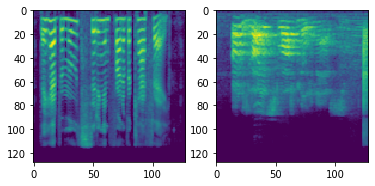

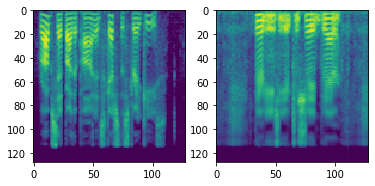

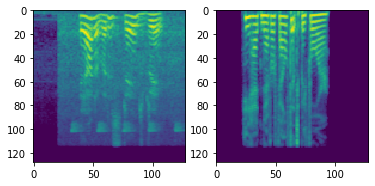

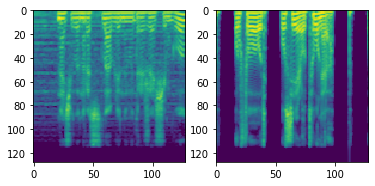

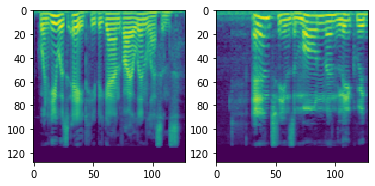

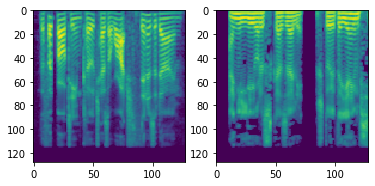

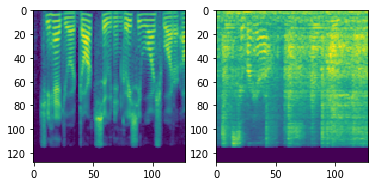

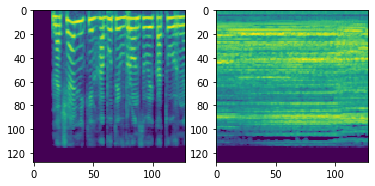

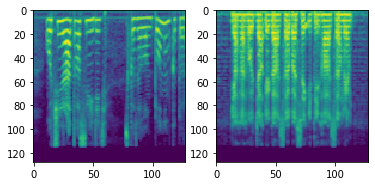

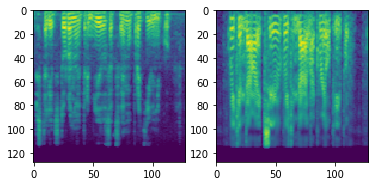

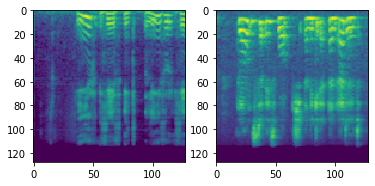

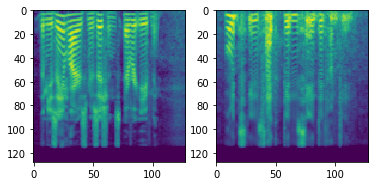

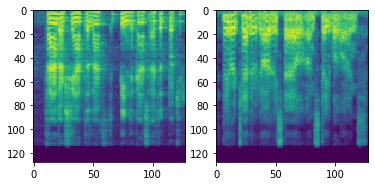

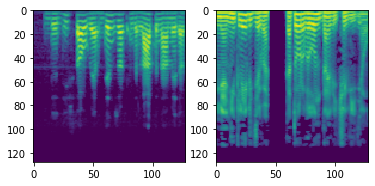

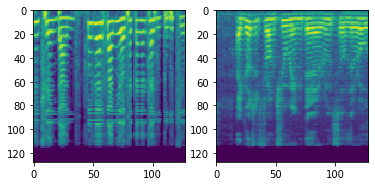

In [101]:
# sample images
for i in range(15):
    real_im = Image.open(df_train[df_train['class'] == '1'].iloc[i]['path'])
    spoof_im = Image.open(df_train[df_train['class'] == '0'].iloc[i]['path'])
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(real_im)
    plt.subplot(1, 2, 2)
    plt.imshow(spoof_im)

In [152]:


train_datagen=ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 width_shift_range=10,
                                 height_shift_range=10,
                                 zoom_range=0.2,
                                 shear_range = 0.2,
                                 horizontal_flip=False)

        
test_datagen=ImageDataGenerator(rescale=1./255.)
target_size = (128,128)

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train, directory=None , 
                                                  x_col="path", y_col='class',
                                                  target_size = target_size, class_mode="binary", 
                                                  drop_duplicates = False, shuffle = True,
                                                  color_mode = 'grayscale',
                                                  batch_size=64)


val_generator=test_datagen.flow_from_dataframe(dataframe=df_test, directory=None, 
                                                x_col="path", y_col='class', 
                                                target_size = target_size,class_mode="binary", 
                                                drop_duplicates = False, shuffle = True, 
                                                color_mode = 'grayscale',
                                                batch_size=64)

Found 66644 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [155]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

er_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(128, 128 ,1)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 256)     

In [156]:
hist = model.fit_generator(train_generator, epochs=30, steps_per_epoch = df_train.shape[0]// 64, 
                           validation_data=val_generator,validation_steps=df_test.shape[0] // 64,
                           callbacks = [ model_checkpoint_callback, er_stop])

Epoch 1/30
1041/1041 [==============================] - 107s 103ms/step - loss: 0.5277 - accuracy: 0.7164 - val_loss: 0.3965 - val_accuracy: 0.8075
Epoch 2/30
1041/1041 [==============================] - 107s 102ms/step - loss: 0.3393 - accuracy: 0.8535 - val_loss: 0.1609 - val_accuracy: 0.9163
Epoch 3/30
1041/1041 [==============================] - 107s 102ms/step - loss: 0.2301 - accuracy: 0.9065 - val_loss: 0.2291 - val_accuracy: 0.9267
Epoch 4/30
1041/1041 [==============================] - 107s 102ms/step - loss: 0.1755 - accuracy: 0.9305 - val_loss: 0.0277 - val_accuracy: 0.9514
Epoch 5/30
1041/1041 [==============================] - 106s 102ms/step - loss: 0.1483 - accuracy: 0.9420 - val_loss: 0.1379 - val_accuracy: 0.9582
Epoch 6/30
1041/1041 [==============================] - 107s 102ms/step - loss: 0.1300 - accuracy: 0.9494 - val_loss: 0.0679 - val_accuracy: 0.9499
Epoch 7/30
1041/1041 [==============================] - 107s 102ms/step - loss: 0.1174 - accuracy: 0.9548 - val_

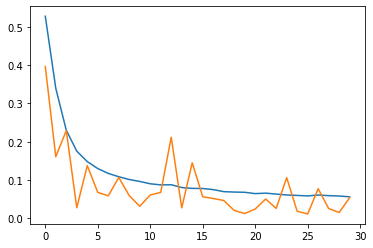

In [157]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [158]:
pred_generator=test_datagen.flow_from_dataframe(dataframe=df_test, directory=None, 
                                                x_col="path", y_col='class', 
                                                target_size = target_size,class_mode="binary", 
                                                drop_duplicates = False, shuffle = False, 
                                                color_mode = 'grayscale',
                                                batch_size=1)
model.load_weights('checkpoint')

pred= model.predict_generator(pred_generator, steps=pred_generator.n//pred_generator.batch_size)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = df_test.to_numpy()
y_true = np.array(dtest[:,1:],dtype=int)

print(classification_report(y_true, y_pred))

Found 2000 validated image filenames belonging to 2 classes.
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [42]:
# read test audio data
path = 'C:/Users/duran/Downloads/Testing_Data'
tests = np.array([f for f in listdir(path) if isfile(join(path, f))])
df_t = pd.DataFrame()
df_t['path'] = tests
df_t['path'] = path + '/' + df_t['path'] 

In [49]:
audio_to_img(df_t, 'Test_data_image')

In [49]:
# read test image data
path = 'C:/Users/duran/Downloads/Test_data_image'
tests = np.array([f for f in listdir(path) if isfile(join(path, f))])
df_t = pd.DataFrame()
df_t['path'] = tests
df_t['path'] = path + '/' + df_t['path'] 

In [160]:
pred_generator=test_datagen.flow_from_dataframe(dataframe=df_t, directory=None, 
                                                x_col="path", 
                                                class_mode = None,
                                                target_size = target_size,
                                                drop_duplicates = False, shuffle = False, 
                                                color_mode = 'grayscale',
                                                batch_size=1)

Found 5000 validated image filenames.


In [161]:
pred= model.predict_generator(pred_generator, steps=pred_generator.n//pred_generator.batch_size)

In [52]:
path = 'C:/Users/duran/Downloads/Testing_Data'
tests = np.array([f for f in listdir(path) if isfile(join(path, f))])

In [145]:
f = open('results.txt', 'w')
for name, conf in zip(tests, pred):
    f.write(name + ', ' + str(conf[0]) + '\n')
f.close()    

In [162]:
result = pd.DataFrame()
result['path'] = tests
result['conf'] = pred
result.to_csv('result.csv')